In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
#import cv2
import types
import random

from utils import *

In [2]:
WIDTH = 384
HEIGHT = 128
SZ = 224
BS = 64
NUM_WORKERS = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
root_dir = Path('../input')
train_dir = root_dir/'train'
test_dir = root_dir/'test'
train_crop_dir = root_dir/'train_crop'
test_crop_dir = root_dir/'test_crop'
old_train_dir = root_dir/'old/train'
bg_dir = root_dir/'sea'
annot_dir = root_dir/'annotation'
learn_path = Path('../')
crop_dir = root_dir/'crop'

### From test_dir generate test_df about image files

In [4]:
list(test_dir.glob('*.*'))[0].name

'184fcdbf7.jpg'

In [5]:
test_imgs = []
for f in test_dir.glob('*.*'):
    test_imgs.append(f.name)

In [6]:
test_df = pd.DataFrame({'Image': test_imgs})
test_df.head()

,Image
0,184fcdbf7.jpg
1,9fa70d5f0.jpg
2,e9c1e71d2.jpg
3,e6c608a11.jpg
4,00379666f.jpg


In [7]:
train_df = pd.read_csv(root_dir/'train.csv')
classes = train_df.Id.unique()
train_imgs = train_df.Image.tolist()
    
data = (
    ImageItemList
        #.from_folder(train_dir)
        .from_df(train_df, train_dir, cols=['Image'])
        #.no_split()
        .split_by_valid_func(lambda path: path) # in newer version of the fastai library there is .no_split that could be used here
        #.label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .label_empty()
        .add_test(ImageItemList.from_df(test_df, test_dir, cols=['Image']))
        .transform(get_transforms(max_zoom=1, max_warp=0., max_rotate=0.0, max_lighting=0.), tfm_y=False, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        #.transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=root_dir)
        .normalize(imagenet_stats)
)

/media/wb/T08/study/fastai/fastai/data_block.py:403: UserWarning: Your training set is empty. Is this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. Is this is by design, pass `ignore_empty=True` to remove this warning.")


In [8]:
data.valid_ds.x

ImageItemList (25361 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050)]...
Path: ../input/train

In [9]:
data.valid_dl.__len__()

397

In [10]:
#check if the orders of df and train_ds are the same
if 0:
    for k, (df_fn, ds_img) in enumerate(zip(train_imgs, data.valid_ds.x)):
        df_img = open_image(train_dir/df_fn)
        if (df_img.size != ds_img.size):
            print(df_fn)
        if k % 1000 == 0:
            print(k, df_img.size, ds_img.size)
    print('comparing over')

In [11]:
#check if the orders of test_df and test_ds are the same
if 0:
    for k, (df_fn, ds_img) in enumerate(zip(test_imgs, data.test_ds.x)):
        df_img = open_image(test_dir/df_fn)
        if (df_img.size != ds_img.size):
            print(df_fn)
        if k % 1000 == 0:
            print(k, df_img.size, ds_img.size)
    print('comparing over')

In [12]:
#data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(12,12))

In [13]:
class FlukeLocater(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [14]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [15]:
learn = Learner(data, FlukeLocater(arch=models.resnet50), loss_func=loss_fn, path=learn_path)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [16]:
learn.load('fluke_location')
learn.model.to(device)

FlukeLocater(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kern

In [17]:
DatasetType.Valid

<DatasetType.Valid: 2>

In [19]:
learn.model.eval()
with torch.no_grad():
    #bboxes, _ = learn.get_preds(data.valid_dl)
    bboxes, _ = learn.get_preds(ds_type=DatasetType.Valid)
    

In [20]:
bboxes.shape

torch.Size([25361, 4])

In [22]:
top0, left0, bottom0, right0 = bboxes[0]
left

NameError: name 'left' is not defined

In [23]:
img0 = open_image(train_dir/train_imgs[0])

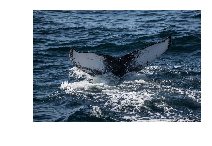

In [24]:
img0.show()

In [25]:
height, width = img0.size
height, width

(700, 1050)

In [26]:
def bb2point(bb, pnts):
    return (bb + 1) / 2 * pnts

In [27]:
bb2point(left0, width)

tensor(214.5048)

In [28]:
def crop_image(img_file, img_bbox, out_file, enlarge_rate=0.02):
    img = PIL.Image.open(img_file)
    width, height = img.size
    top0, left0, bottom0, right0 = img_bbox

    #calculate the bounding box
    left = bb2point(left0, width).item()
    top = bb2point(top0, height).item()
    right = bb2point(right0, width).item()
    bottom = bb2point(bottom0, height).item()

    #enlarge the bounding box to make it robust
    bb_width = right - left
    bb_height = bottom - top
    x_margin = bb_width * enlarge_rate
    y_margin = bb_height * enlarge_rate * 3
    left = int(round(max(0, left-x_margin)))
    top = int(round(max(0, top-y_margin)))
    right = int(round(min(width, right+x_margin)))
    bottom = int(round(min(height, bottom+y_margin)))
    
    crop = img.crop((left, top, right, bottom))
    crop.save(out_file, 'JPEG')
    #return left, top, right, bottom



In [30]:
crop_image(train_dir/train_imgs[0], bboxes[0], train_crop_dir/train_imgs[0], enlarge_rate=0.05)

In [31]:
Path(train_crop_dir/train_imgs[0]).exists()

True

In [32]:
def crop_images(src_dir, src_imgs, src_bboxes, crop_dir, enlarge_rate=0.05):
    for k, (img, bbox) in enumerate(zip(src_imgs, src_bboxes)):
        if Path(crop_dir/img).exists():
            continue
        crop_image(src_dir/img, bbox, crop_dir/img, enlarge_rate)
        if k % 1000 == 0:
            print(k)

In [34]:
#crop the train images
crop_images(train_dir, train_imgs, bboxes, train_crop_dir, enlarge_rate=0.05)

18000
19000
20000
21000
22000
23000
24000
25000


In [35]:
#calcualte bboxes for test data
learn.model.eval()
with torch.no_grad():
    test_bboxes, _ = learn.get_preds(ds_type=DatasetType.Test)
    

In [36]:
#crop the test images
crop_images(test_dir, test_imgs, test_bboxes, test_crop_dir, enlarge_rate=0.05)

0
1000
2000
3000
4000
5000
6000
7000


In [ ]:
# preds, targs = learn.get_preds()

# predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
# targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

# def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
#     y_min, x_min, y_max, x_max = map(int, bbox)
#     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
#     if target is not None:
#         y_min, x_min, y_max, x_max = map(int, target)
#         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
#     return img

# def cv_read(path):    
#     im = cv2.imread(path, cv2.IMREAD_COLOR)
#     return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# # Targets are in green, predictions in red.
# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
# plt.figure(figsize=(12,12))
# plt.axis('off')
# plt.imshow(montage(np.stack(ims), multichannel=True))